# Dog Breeds
https://www.kaggle.com/c/dog-breed-identification

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Build the model

Set the paths to the home folder of the dataset. Set the batch size to start with.

In [6]:
PATH = "data/dogbreeds/"
sz = 224
bs = 32

Set the validation indices and give it to the learner. Define augmentations and pass it to data loader.

In [7]:
val_idxs = get_cv_idxs(10222, cv_idx=3)

arch = resnext101_64
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

data = ImageClassifierData.from_csv(PATH, folder="train", csv_fname=f"{PATH}labels.csv", val_idxs=val_idxs,
                                    bs=bs, tfms=tfms, suffix=".jpg", test_name="test")

In [8]:
torch.manual_seed(43)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
lrf = learn.lr_find()

A Jupyter Widget

  2%|▏         | 4/256 [00:01<01:19,  3.18it/s, loss=5.55]

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 84%|████████▍ | 215/256 [00:02<00:00, 80.10it/s, loss=11.8]


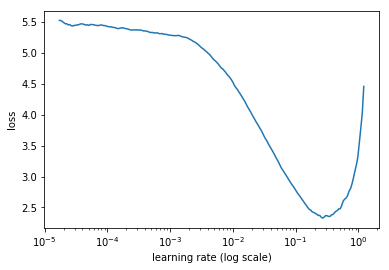

In [9]:
learn.sched.plot()

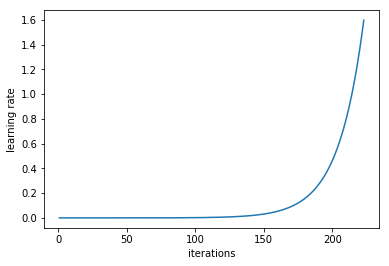

In [10]:
learn.sched.plot_lr()

In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
learn.fit(0.01, 3)

A Jupyter Widget

  2%|▏         | 5/256 [00:00<00:12, 19.59it/s, loss=5.19]

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       0.69954  0.36718  0.90367]                        
[ 1.       0.4174   0.3102   0.91176]                        
[ 2.       0.30128  0.27888  0.91288]                        



In [12]:
learn.precompute = False

In [13]:
learn.fit(0.01, 5, cycle_len=1)

A Jupyter Widget

  1%|          | 2/256 [00:00<01:41,  2.51it/s, loss=0.302]

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       0.31463  0.2651   0.92076]                        
[ 1.       0.27924  0.26213  0.91783]                        
[ 2.       0.25852  0.26038  0.92125]                        
[ 3.       0.26363  0.25685  0.92173]                        
[ 4.       0.23998  0.26986  0.91783]                        



Let's plot the learning rate. As we have given `cycle_len=1`, the lr should reset after every iteration.

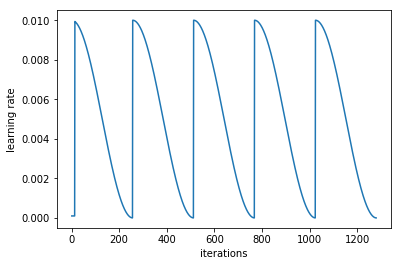

In [14]:
learn.sched.plot_lr()

In [15]:
learn.save("dogbreeds_1")

In [16]:
learn.load("dogbreeds_1")

# Differential learning rates

In [17]:
learn.unfreeze()

In [18]:
lrf = learn.lr_find()

A Jupyter Widget

  0%|          | 0/256 [00:00<?, ?it/s]

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 55%|█████▌    | 141/256 [01:15<01:01,  1.87it/s, loss=1.59] 

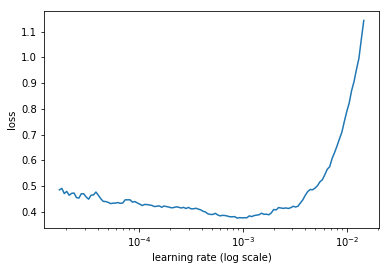

In [19]:
learn.sched.plot()

In [20]:
lr = np.array([1e-9, 1e-6, 1e-3])

In [21]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget


  0%|          | 0/256 [00:00<?, ?it/s]

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



  2%|▏         | 5/256 [00:03<02:45,  1.51it/s, loss=0.471] 

Exception in thread Thread-16:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-17:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeErro

[ 0.       0.41405  0.35598  0.88937]                        
[ 1.       0.44822  0.3545   0.88839]                        
[ 2.       0.43915  0.35194  0.89425]                        
[ 3.       0.40595  0.34158  0.89621]                        
[ 4.       0.39882  0.34172  0.89523]                        
[ 5.       0.39729  0.34053  0.89572]                        
[ 6.       0.40423  0.33696  0.89621]                        



# Predict on test set

In [ ]:
#preds = np.exp(learn.predict(is_test=True))

In [ ]:
#fnames = [x.split("/")[1].split(".")[0] for x in data.test_dl.dataset.fnames]

In [ ]:
#final = pd.read_csv(f"{PATH}/sample_submission.csv")
#final.loc[:,1:] = preds

In [ ]:
#f = "submit1.csv"
#final.to_csv(f"{PATH}{f}", compression="gzip", index=False)

#from IPython.display import FileLink
#FileLink(f"{PATH}{f}")